In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import Data, Preprocessing

In [21]:
save_path = Data.createSavePath('ana_kde')

'../data/ana_kde'

In [ ]:
def find_nearest(array, x):
    array = np.asarray(array)
    idx = (np.abs(array - x)).argmin()
    return idx

# Use gaze_data['TimeStamp'] to segment gaze_data by event_data['TimeStamp']
def epochGazeData(gaze_data, event_data):
    gaze_data_epoch = []
    for iEvent in range(int(len(event_data) / 2)):
        onset = event_data["TimeStamp"][2 * iEvent]
        offset = event_data["TimeStamp"][2 * iEvent + 1]
        onset_nearest = find_nearest(gaze_data["TimeStamp"], onset)
        offset_nearest = find_nearest(gaze_data["TimeStamp"], offset) + 1
        gaze_data_epoch.append(gaze_data[onset_nearest:offset_nearest])
    return gaze_data_epoch


def compute_density(samples, area=(-1, 1, -1, 1), kernel_bandwidth=None):
    """Compute the density of samples on a 2D grid"""
    from scipy.stats import gaussian_kde

    x, y = samples.T
    if kernel_bandwidth is None:
        kde = gaussian_kde(samples.T)
    else:
        kde = gaussian_kde(kernel_bandwidth)

    x_grid = np.linspace(area[0], area[1], 100)
    y_grid = np.linspace(area[2], area[3], 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    Z = Z / Z.sum()
    Z = Z.reshape(X.shape)
    return Z, X, Y


def plot_density_estimation(ax, Z, x, y, entropy=None, colorbar=False):
    im = ax.imshow(Z, origin="lower", aspect="auto", extent=[-1, 1, -1, 1], cmap="viridis")
    ax.scatter(x, y, s=2, color="k", alpha=0.1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    if entropy is not None:
        ax.set_title("Density estimation")
    else:
        ax.set_title(f"Entropy = {entropy:.2f}")
    if colorbar:
        plt.colorbar(im, ax=ax)
    ax.set_aspect("equal", adjustable="box")


def compute_entropy(Z):
    # prevent log(0)
    Z = Z + 1e-10
    entropy = -np.sum(Z * np.log2(Z))
    return entropy


#%%
subjIDs = range(1, 11)
df_trial_all = []
for subjID in subjIDs:
    df_trial = Data.loadTrainInfo(subjID, 2)
    # add subjID to df_trial
    df_trial["subject"] = subjID
    metadata, gaze_data, event_data = Data.loadEyeData(subjID, 2)
    gaze_data_epoch = epochGazeData(gaze_data, event_data)
    df_trial_ = df_trial.sort_values(by=["delay", "trial"]).reset_index(inplace=False, drop=True)

    entropys = []
    for i in range(len(df_trial_)):
        print(i)
        data = gaze_data_epoch[df_trial_["trial"][i]][["GazePointX", "GazePointY"]].values
        data = data[~np.isnan(data).any(axis=1)]
        Z, X, Y = compute_density(data)
        entropy = compute_entropy(Z.flatten())
        entropys.append(entropy)

    df_trial_["entropy"] = entropys
    df_trial_all.append(df_trial_)

df_trial_all = pd.concat(df_trial_all, axis=0)


filepath = Data.createFilePath(save_path, 'kde.csv')
df_trial_all.to_csv(filepath, index=False)

Load data directly

In [10]:
datapath = '../data/ana_kde/kde.csv'
df = pd.read_csv(datapath)
iSubjIDs = np.unique(df["subject"])

corrs = []
for iSubjIDs in iSubjIDs:
    # filter out subjects
    df_ = df[df["subject"] == iSubjIDs]
    
    # compute correlation between ratings and entropy
    corr = df_[["entropy", "rating"]].corr()
    
    # extract correlation coefficient
    corr = corr["rating"]["entropy"]
    corrs.append(corr)
        

In [12]:
# one sample t test on correlation coefficients 
from scipy.stats import ttest_1samp
ttest_1samp(corrs, 0)

TtestResult(statistic=3.1204453748550334, pvalue=0.012309786219970626, df=9)

/home/acercyc/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/acercyc/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


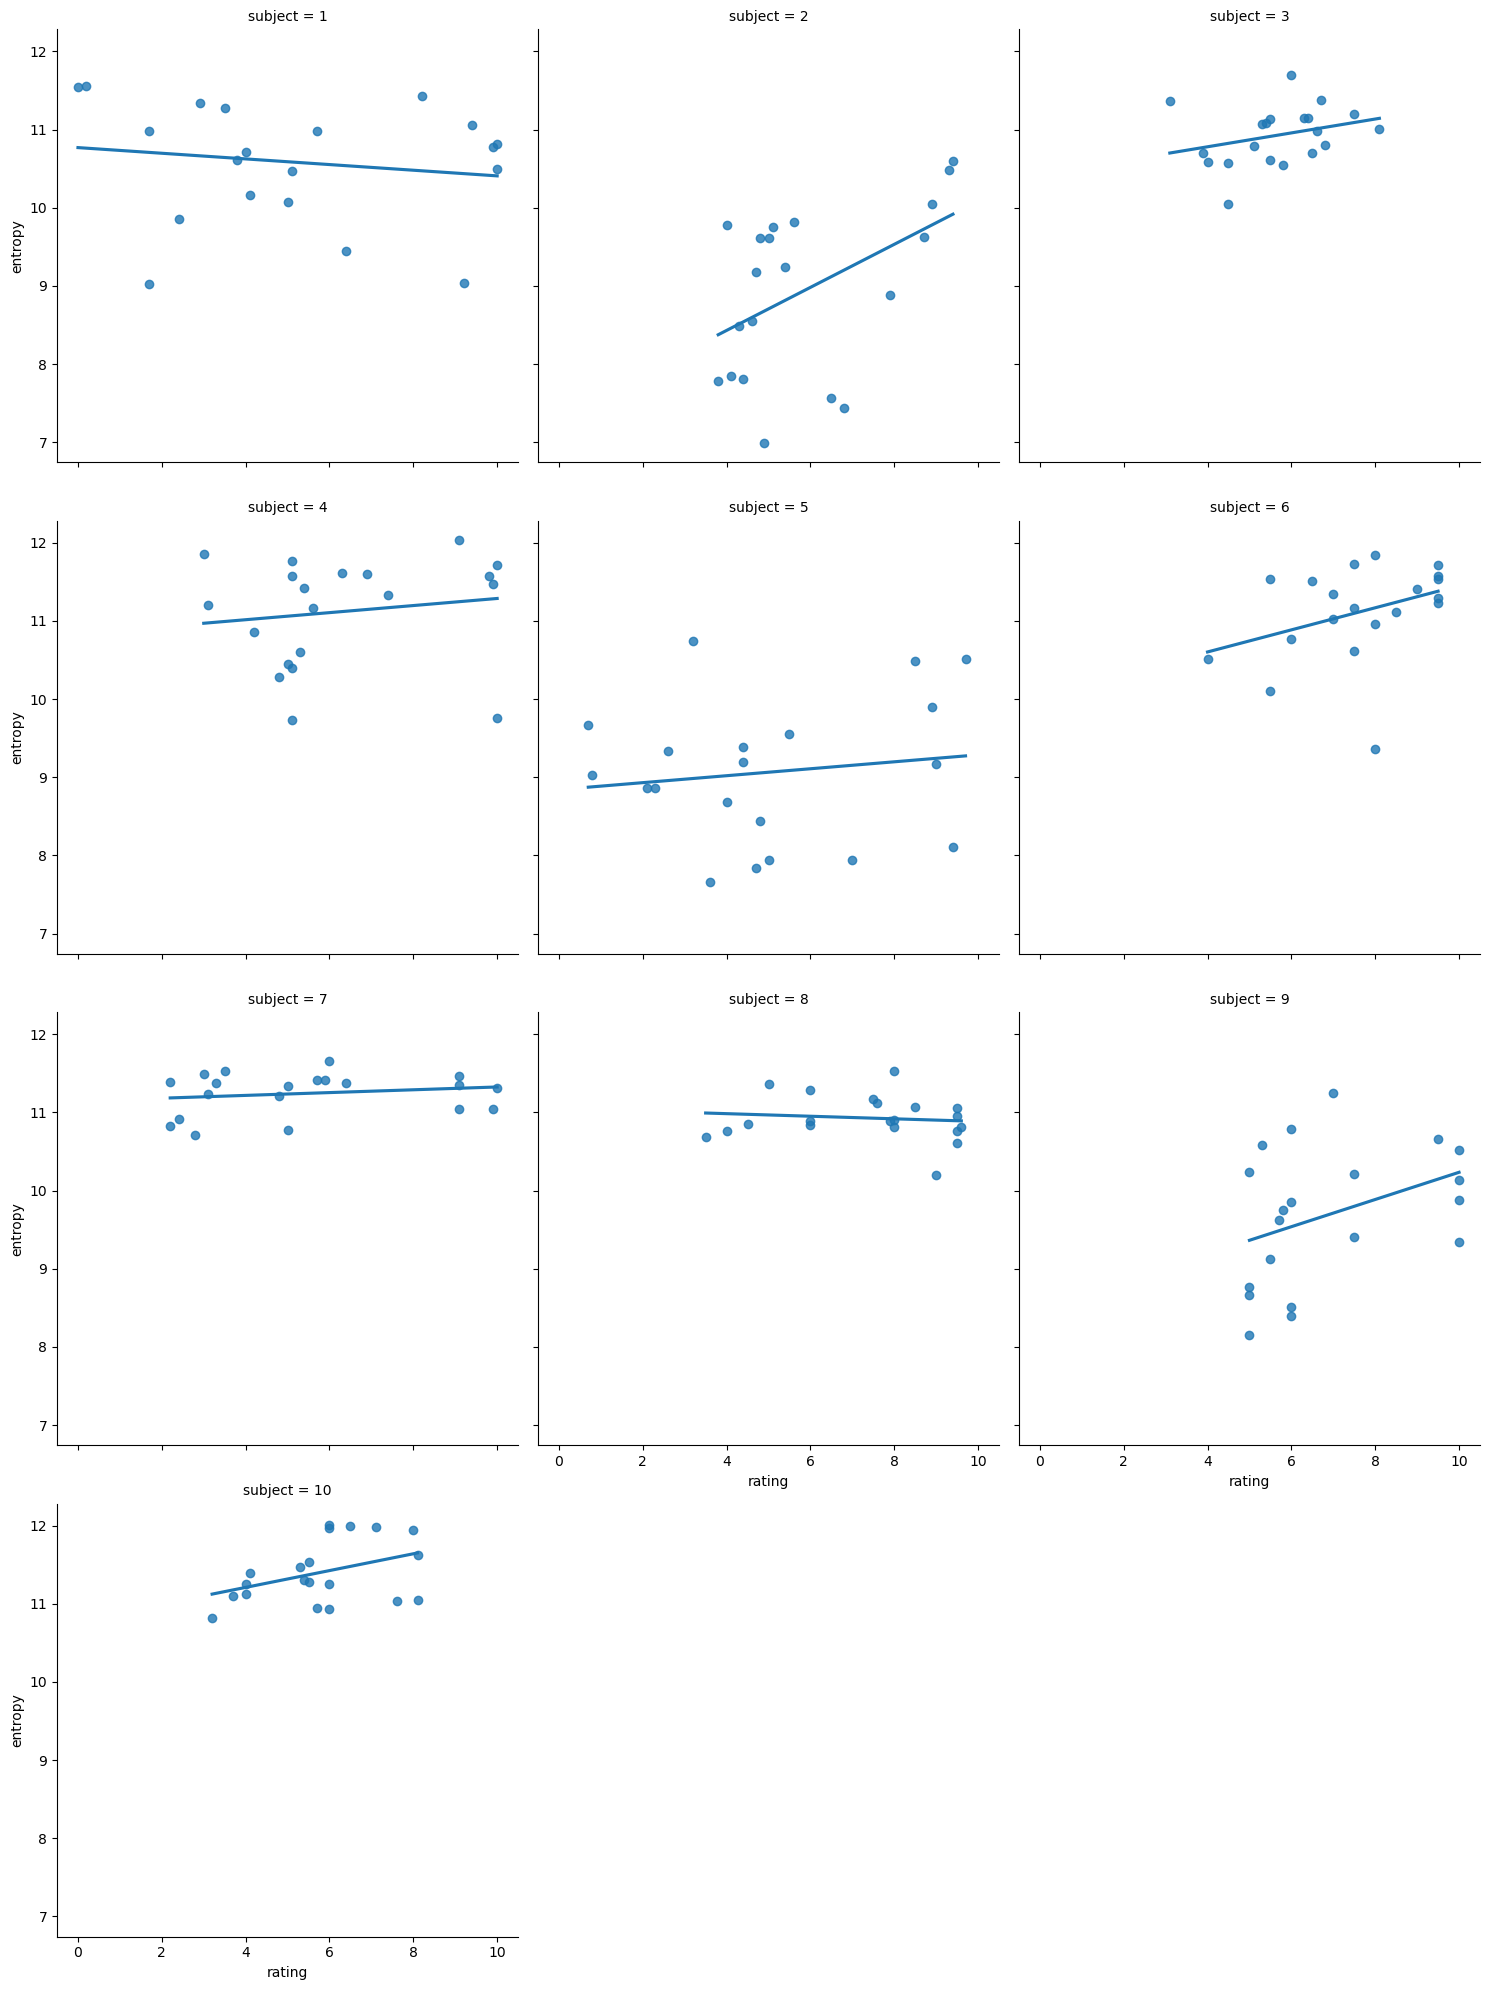

In [20]:
# Plot regression lines for rating and entropy
sns.lmplot(x="rating", y="entropy", data=df, col="subject", col_wrap=3, ci=None, scatter=True)